<a href="https://colab.research.google.com/github/Clarkdrengen/PML_2023/blob/main/PML_Part_B_%E2%80%93_Function_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part B – Function Fitting

In [ ]:
!pip3 install pyro-ppl
!pip3 install arviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
from pyro.distributions import LogNormal
import torch.distributions as tdist
import arviz
import pyro
import random
import pyro.contrib.gp as gp
pyro.set_rng_seed(1)

## B.1 Fitting a GP with Pyro

In [ ]:
def f(x):
    return torch.sin(20*x) + 2*torch.cos(14*x) - 2*torch.sin(6*x)

xs = torch.tensor([-1.,-0.5,0,0.5,1])
ys = f(xs)

In [ ]:
pyro.set_rng_seed(1)

kernel = gp.kernels.RBF(input_dim=1)

kernel.lengthscale = pyro.nn.PyroSample(LogNormal(-1.0,1.0))

kernel.variance = pyro.nn.PyroSample(LogNormal(0.0,2.0))

gpr = gp.models.GPRegression(xs, ys, kernel, noise = torch.tensor([0.0001]))

In [ ]:
pyro.set_rng_seed(1)

nuts_kernel = pyro.infer.NUTS(gpr.model,jit_compile=True)

mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=500)

mcmc.run()

ls_name = "kernel.lengthscale"

posterior_ls = mcmc.get_samples()[ls_name]

vs_name = "kernel.variance"

posterior_vs = mcmc.get_samples()[vs_name]

posterior_hyperparameter_samples = mcmc.get_samples()

/usr/local/lib/python3.8/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1)

## Deliverables 1: Scatter plot on log-log-scale of N = 500 samples from p(θ | D).

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

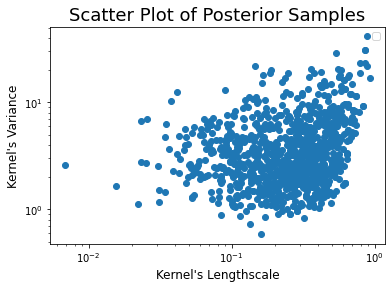

In [ ]:
from google.colab import files
plt.scatter(posterior_ls, posterior_vs)
plt.legend()
plt.title("Scatter Plot of Posterior Samples", fontsize=18)
plt.yscale('log') 
plt.xscale('log') 
plt.ylabel("Kernel's Variance", fontsize=12)
plt.xlabel("Kernel's Lengthscale",fontsize=12)
plt.savefig('Posterior Scatter Plot.png', dpi = 1000)
files.download("Posterior Scatter Plot.png") 
plt.show()

In [ ]:
posterior_ls.shape

torch.Size([1000])

In [ ]:
posterior_vs

tensor([ 1.2889,  6.2264,  3.1196,  2.4832,  1.3068,  1.0763,  1.6226,  1.4755,
         1.0735,  1.9360,  1.6305,  2.3014,  1.5695,  2.9782,  3.3259,  3.3259,
         2.2531,  3.2253,  4.7003,  1.2091,  1.7803,  7.8345,  3.3653,  7.3077,
         8.0211,  7.1785,  4.3670,  3.9362,  1.4060,  5.5857,  5.0299,  1.4556,
         1.5985,  1.1564,  1.4112,  2.5830,  2.5830,  2.3267,  2.1630,  1.6229,
         4.5530,  1.2763,  1.3722,  1.0672,  2.1792,  2.1465,  3.7633,  1.5178,
         7.4957,  4.2126,  2.6461,  1.1826,  2.6439,  1.5425,  2.5455,  7.8305,
        13.2136, 15.1671,  2.6619,  2.0805,  2.7848,  2.4280,  1.9080,  1.4052,
         1.4052,  2.1317,  2.6370,  2.0910,  1.6114,  1.5005,  1.9659,  1.9383,
         1.7326,  1.5896,  1.7847, 10.6328,  3.3791,  2.9294,  3.6950,  2.5631,
         2.4033,  1.9279,  3.2746,  2.1099,  2.3591,  2.4976,  7.1714,  1.3333,
         1.2605,  1.6068,  2.2615,  3.7234,  2.0405,  1.5469,  4.7794,  3.3568,
         4.4829,  1.1484,  0.8812,  1.12

**Accessing the quality of the samples via ArviZ.**

In [ ]:
pyro.set_rng_seed(1)

data = arviz.from_pyro(mcmc)

summary = arviz.summary(data)

summary

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel.lengthscale,0.298,0.174,0.031,0.610,0.011,0.008,269.0,338.0,1.00
kernel.variance,4.371,4.006,0.728,11.134,0.280,0.198,271.0,250.0,1.01


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a016a5970>,
      dtype=object)

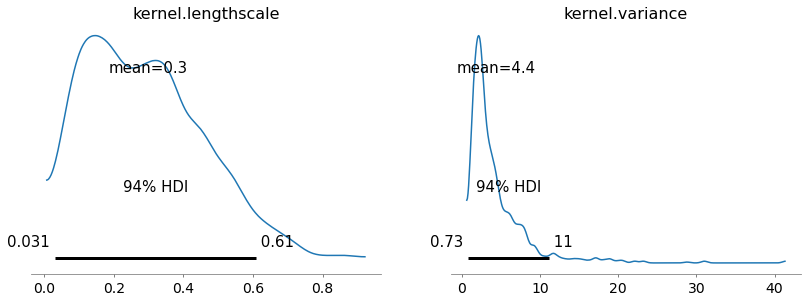

In [ ]:
pyro.set_rng_seed(1)

arviz.plot_posterior(data)


# plt.savefig('posteriorplot.png', dpi = 1000)
# from google.colab import files
# files.download("posteriorplot.png") 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a016c0610>,
      dtype=object)

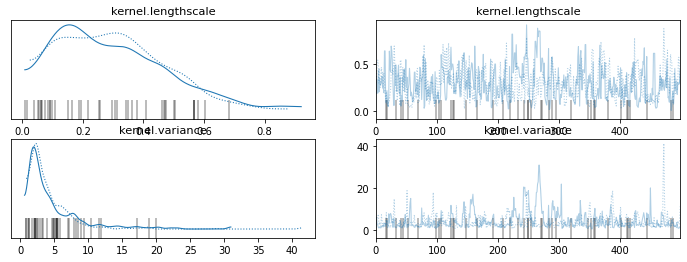

In [ ]:
pyro.set_rng_seed(1)

arviz.plot_trace(data)

# plt.savefig('traceplot.png', dpi = 1000)
# from google.colab import files
# files.download('traceplot.png') 


### B.1.3

In [ ]:
x_test = torch.linspace(-1,1,10)

In [ ]:
x_test

tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])

In [ ]:
posterior_predictive=pyro.infer.Predictive(gpr,posterior_hyperparameter_samples,num_samples=100)

/usr/local/lib/python3.8/dist-packages/pyro/infer/predictive.py:202: UserWarning: Sample's leading dimension size 1000 is different from the provided 100 num_samples argument. Defaulting to 1000.
  warnings.warn(


In [ ]:
posterior_predictive

Predictive(
  (model): GPRegression(
    (kernel): RBF()
  )
)

We just have to understand the syntax for `pyro.infer.Predictive`.

**B.1.3**
Idea 1

In [ ]:

kernel_test = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05)
)
gpr_test = gp.models.GPRegression(xs, ys, kernel_test, noise=torch.tensor(0.0001))

In [ ]:
x_test

tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])

In [ ]:
gpr_test.forward(x_test)

(tensor([-1.1983,  0.3660,  2.0281,  2.8161,  2.4565,  1.5012,  0.7716,  0.7420,
          1.2593,  1.7452], grad_fn=<AddBackward0>),
 tensor([1.0109e-04, 3.4243e-01, 3.1594e-02, 1.7598e-01, 9.1507e-02, 9.1506e-02,
         1.7598e-01, 3.1592e-02, 3.4243e-01, 1.0014e-04],
        grad_fn=<ExpandBackward0>))

Remember this is the proir.

In [ ]:
gpr_test.forward(x_test)[0]

tensor([-1.1983,  0.3660,  2.0281,  2.8161,  2.4565,  1.5012,  0.7716,  0.7420,
         1.2593,  1.7452], grad_fn=<AddBackward0>)

In [ ]:
gpr_test.forward(x_test)[1]

tensor([1.0109e-04, 3.4243e-01, 3.1594e-02, 1.7598e-01, 9.1507e-02, 9.1506e-02,
        1.7598e-01, 3.1592e-02, 3.4243e-01, 1.0014e-04],
       grad_fn=<ExpandBackward0>)

To find $m(x^{*})$ and $v(x^{*})$, we will use `.forward`.

We will now use a test feature data set

In [ ]:
posterior_vs.shape

torch.Size([1000])

In [ ]:
means = torch.tensor([])
variances = torch.tensor([])
pyro.clear_param_store()

for i in range(1000):
    pyro.clear_param_store()
    
    kernels = gp.kernels.RBF(input_dim = 1, variance = posterior_vs[i], lengthscale=posterior_ls[i])
    
    gprs = gp.models.GPRegression(xs,ys,kernel=kernels,noise=torch.tensor([0.0001]))

    means = torch.cat((means,gprs.forward(x_test)[0]),-1)

    variances = torch.cat((variances,gprs.forward(x_test)[1]),0)


In [ ]:
# Reshape the tensor two 10 by 1000.

In [ ]:
means = torch.reshape(means,(10,1000))

Reshaping `variances` in the same way.

In [ ]:
variances = torch.reshape( variances, (10,1000) )

The $m(x^{*})$ is estimated as the mean of all the means. Assuming i.i.d., the $v(x^{*})$ is also estimated as the mean.

In [ ]:
means_estimate = torch.mean(means,dim=1) # mean along the rows.

In [ ]:
means_estimate.shape

torch.Size([10])

In [ ]:
means_estimate

tensor([1.0648, 1.0959, 1.0444, 1.0457, 0.9618, 0.9995, 1.1225, 1.0934, 1.0737,
        1.0515], grad_fn=<MeanBackward1>)

In [ ]:
variances_estimates = torch.mean( variances, dim=1 )

In [ ]:
variances_estimates

tensor([0.6885, 0.6768, 0.7739, 0.9962, 1.0366, 0.8863, 0.5355, 0.7313, 0.9927,
        0.7796], grad_fn=<MeanBackward1>)

## B.2 Bayesian Optimization

In [ ]:
x_candidate = torch.linspace(-1,1,200)

In [ ]:
x_candidate.shape

torch.Size([200])

In [ ]:
x_candidate

tensor([-1.0000, -0.9899, -0.9799, -0.9698, -0.9598, -0.9497, -0.9397, -0.9296,
        -0.9196, -0.9095, -0.8995, -0.8894, -0.8794, -0.8693, -0.8593, -0.8492,
        -0.8392, -0.8291, -0.8191, -0.8090, -0.7990, -0.7889, -0.7789, -0.7688,
        -0.7588, -0.7487, -0.7387, -0.7286, -0.7186, -0.7085, -0.6985, -0.6884,
        -0.6784, -0.6683, -0.6583, -0.6482, -0.6382, -0.6281, -0.6181, -0.6080,
        -0.5980, -0.5879, -0.5779, -0.5678, -0.5578, -0.5477, -0.5377, -0.5276,
        -0.5176, -0.5075, -0.4975, -0.4874, -0.4774, -0.4673, -0.4573, -0.4472,
        -0.4372, -0.4271, -0.4171, -0.4070, -0.3970, -0.3869, -0.3769, -0.3668,
        -0.3568, -0.3467, -0.3367, -0.3266, -0.3166, -0.3065, -0.2965, -0.2864,
        -0.2764, -0.2663, -0.2563, -0.2462, -0.2362, -0.2261, -0.2161, -0.2060,
        -0.1960, -0.1859, -0.1759, -0.1658, -0.1558, -0.1457, -0.1357, -0.1256,
        -0.1156, -0.1055, -0.0955, -0.0854, -0.0754, -0.0653, -0.0553, -0.0452,
        -0.0352, -0.0251, -0.0151, -0.00

In [ ]:


gpr(x_candidate)

(tensor([-1.1976, -1.1144, -1.0307, -0.9466, -0.8623, -0.7776, -0.6928, -0.6078,
         -0.5227, -0.4376, -0.3525, -0.2676, -0.1828, -0.0983, -0.0140,  0.0698,
          0.1533,  0.2363,  0.3187,  0.4006,  0.4817,  0.5622,  0.6418,  0.7206,
          0.7985,  0.8754,  0.9513,  1.0262,  1.0999,  1.1724,  1.2437,  1.3137,
          1.3823,  1.4496,  1.5155,  1.5798,  1.6427,  1.7039,  1.7636,  1.8217,
          1.8780,  1.9327,  1.9856,  2.0367,  2.0860,  2.1334,  2.1790,  2.2227,
          2.2646,  2.3044,  2.3424,  2.3783,  2.4123,  2.4443,  2.4744,  2.5024,
          2.5284,  2.5524,  2.5744,  2.5944,  2.6124,  2.6284,  2.6424,  2.6544,
          2.6645,  2.6726,  2.6788,  2.6831,  2.6855,  2.6861,  2.6847,  2.6816,
          2.6767,  2.6701,  2.6617,  2.6516,  2.6399,  2.6266,  2.6117,  2.5952,
          2.5773,  2.5579,  2.5371,  2.5150,  2.4916,  2.4669,  2.4410,  2.4139,
          2.3858,  2.3565,  2.3263,  2.2952,  2.2631,  2.2303,  2.1966,  2.1623,
          2.1272,  2.0916,  

In [ ]:
# Doing some testing.

kernel_test = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05)
)
gpr_test = gp.models.GPRegression(xs, ys, kernel_test, noise=torch.tensor(0.0001))



In [ ]:
gpr_test.forward(x_candidate)

(tensor([-1.1983, -1.1437, -1.0872, -1.0287, -0.9684, -0.9062, -0.8422, -0.7766,
         -0.7093, -0.6405, -0.5702, -0.4985, -0.4255, -0.3512, -0.2758, -0.1994,
         -0.1220, -0.0437,  0.0353,  0.1150,  0.1952,  0.2759,  0.3570,  0.4383,
          0.5197,  0.6012,  0.6826,  0.7638,  0.8447,  0.9252,  1.0052,  1.0845,
          1.1632,  1.2410,  1.3179,  1.3938,  1.4685,  1.5420,  1.6142,  1.6850,
          1.7542,  1.8219,  1.8879,  1.9521,  2.0145,  2.0750,  2.1335,  2.1899,
          2.2442,  2.2964,  2.3463,  2.3939,  2.4393,  2.4822,  2.5228,  2.5608,
          2.5965,  2.6296,  2.6602,  2.6883,  2.7138,  2.7367,  2.7571,  2.7750,
          2.7903,  2.8030,  2.8132,  2.8209,  2.8262,  2.8289,  2.8292,  2.8271,
          2.8227,  2.8159,  2.8068,  2.7956,  2.7821,  2.7665,  2.7488,  2.7291,
          2.7075,  2.6840,  2.6586,  2.6315,  2.6027,  2.5724,  2.5404,  2.5071,
          2.4723,  2.4363,  2.3990,  2.3606,  2.3211,  2.2807,  2.2394,  2.1973,
          2.1544,  2.1109,  

In [ ]:
means_f = torch.tensor([])
variances_f = torch.tensor([])
pyro.clear_param_store()

for i in range(1000):
    pyro.clear_param_store()
    
    kernels_f = gp.kernels.RBF(input_dim = 1, variance = posterior_vs[i], lengthscale=posterior_ls[i])
    
    gprs_f = gp.models.GPRegression(xs,ys,kernel=kernels_f,noise=torch.tensor([0.0001]))
    
    means_f = torch.cat((means_f,gprs.forward(x_candidate)[0]),-1)

    variances_f = torch.cat((variances_f,gprs.forward(x_candidate)[1]),0)


In [ ]:
means_f = torch.reshape( means_f, (200,1000) )

means_f_estimates = torch.mean( means_f, dim=1 )

In [ ]:
variances_f = torch.reshape( variances_f, (200,1000) )

variances_f_estimates = torch.mean( variances_f, dim=1 )

In [ ]:
means_f_estimates.shape

torch.Size([200])

Now the idea is to generate a tensor of dim 200. This is $f^{*}$ values. $f^{*}$ corresponds to $x^{*} \in [-1,1]$.

In [ ]:
f_asterisk = torch.tensor([])

for i in range(200):
    # torch.manual_seed(1) — If I add this, then it will of course be the same value you get.
    f_asterisk = torch.cat( ( f_asterisk, torch.normal(mean=means_f_estimates[i].data,std=torch.sqrt(variances_f_estimates[i]).data, size=(1,)) ), dim=-1)



In [ ]:
torch.normal(mean=0.0,std=1.0, size=(1,))

tensor([0.2214])

In [ ]:
means_f_estimates[3]

tensor(1.3601, grad_fn=<SelectBackward0>)

In [ ]:
torch.normal(mean=means_f_estimates[1].data,std=variances_f_estimates[1].data, size=(1,)) 

tensor([1.3520])

In [ ]:
means_f_estimates[1].data

tensor(1.3601)

In [ ]:

f_asterisk
# The are all 

tensor([1.6107, 1.4612, 1.3834, 1.5955, 1.1888, 1.2971, 0.7831, 1.5047, 0.9707,
        1.1467, 1.0220, 1.3380, 1.2860, 0.9942, 1.5201, 1.4613, 1.2005, 1.1665,
        0.7642, 1.3134, 2.7192, 0.6662, 1.9658, 0.8762, 1.4834, 1.1785, 1.8826,
        2.3182, 1.5157, 0.9857, 1.0160, 1.5655, 1.4018, 0.5041, 1.5899, 1.3076,
        1.6749, 1.2662, 1.0558, 1.4497, 1.4683, 1.6214, 1.1202, 1.6933, 1.1008,
        1.5318, 1.4704, 1.0449, 1.1507, 1.6008, 1.2097, 1.1111, 0.7376, 1.7315,
        1.3441, 1.0491, 1.4788, 0.9299, 1.5030, 1.2530, 0.3875, 0.8181, 1.5499,
        1.5661, 1.2063, 1.7898, 0.9389, 1.4927, 1.0682, 1.3043, 1.5977, 1.7744,
        1.3956, 1.8292, 0.8501, 1.5540, 1.0974, 1.2969, 0.9812, 0.7358, 1.6669,
        1.3811, 1.7897, 1.1582, 1.6098, 0.7552, 1.2173, 0.1847, 1.3224, 1.0868,
        1.8416, 1.3593, 0.9451, 1.5880, 1.6247, 1.0567, 1.9429, 1.9160, 1.9645,
        0.7811, 1.7449, 1.2835, 0.8726, 1.6719, 1.1289, 0.8690, 1.0026, 1.6133,
        1.8006, 1.2377, 2.0717, 1.1454, 

Either something is wrong, or the GP regression model is bad. All of the f* are positive. This seems to be very unreasonable.

In [ ]:
torch.argmin(f_asterisk)

tensor(87)

In [ ]:
x_candidate[86]

tensor(-0.1357)

In [ ]:
means_bo = torch.tensor([])
variances_bo = torch.tensor([])
xs_bo = xs
ys_bo = ys

x_asterisk = torch.linspace(-1,1,200)

for k in range(10):

    for i in range(1000):
    
        pyro.clear_param_store()
    
        kernels_bo = gp.kernels.RBF(input_dim = 1, variance = posterior_vs[i], lengthscale=posterior_ls[i])
    
        gprs_bo = gp.models.GPRegression(xs_bo,ys_bo,kernel=kernels_bo,noise=torch.tensor([0.0001]))

        means_bo = torch.cat((means_bo,gprs_bo.forward(x_asterisk)[0]),-1)

        variances_bo = torch.cat((variances_bo,gprs_bo.forward(x_asterisk)[1]),0)
    
    means_bo = torch.reshape( means_bo, (200,1000) )

    means_bo_estimates = torch.mean( means_bo, dim=1 )

    variances_bo = torch.reshape( variances_bo, (200,1000) )

    variances_bo_estimates = torch.mean( variances_bo, dim=1 )


    f_bo = torch.tensor([])

    for i in range(200):
        # torch.manual_seed(1) — If I add this, then it will of course be the same value you get.
        f_bo = torch.cat( ( f_bo, torch.normal(mean=means_bo_estimates[i].data,std=torch.sqrt(variances_bo_estimates[i]).data, size=(1,)) ), dim=-1)

    
    ys_bo = torch.cat( (ys_bo, f(torch.argmin(f_bo)).unsqueeze(0)), dim=0 )
    
    xs_bo = torch.cat( (xs_bo, x_asterisk[torch.argmin(f_bo)].unsqueeze(0)), dim=0 )



RuntimeError: ignored

In [ ]:

x_asterisk = torch.linspace(-1,1,200)

In [ ]:
means_bo = torch.tensor([])
variances_bo = torch.tensor([])
xs_bo = xs
ys_bo = ys

x_asterisk = torch.linspace(-1,1,200)


for i in range(1000):
    
    pyro.clear_param_store()
    
    kernels_bo = gp.kernels.RBF(input_dim = 1, variance = posterior_vs[i], lengthscale=posterior_ls[i])
    
    gprs_bo = gp.models.GPRegression(xs_bo,ys_bo,kernel=kernels_bo,noise=torch.tensor([0.0001]))

    means_bo = torch.cat((means_bo,gprs_bo.forward(x_asterisk)[0]),-1)

    variances_bo = torch.cat((variances_bo,gprs_bo.forward(x_asterisk)[1]),0)

In [ ]:
means_bo

tensor([-1.1981, -1.1531, -1.1055,  ...,  1.7176,  1.7319,  1.7452],
       grad_fn=<CatBackward0>)